In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [1062]:
players = pd.read_csv('data/players.csv')
players_data = pd.read_csv('data/player_data.csv')
season_stats = pd.read_csv('data/Seasons_Stats.csv')
labels = pd.read_csv('data/labels.csv')

## Steps
#### Training
* Get a list of all historical players
* Get labels and features for these players (roughly 400)
* Get labels and features for 300 historical players with no all nba selections
* Select row with max PER
* train data
* test against current players with labels

In [859]:
pd.set_option('max_columns', 800)


In [1019]:
players_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


In [1018]:
season_stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [1105]:
historical_players = players_data[players_data.year_end < 2018]

# get labels
labelled_historical_players = pd.merge(labels,historical_players.drop_duplicates(subset='name', keep="last"), on='name', how='inner')

idx = season_stats.groupby(['Player'])['PER'].transform(max) == season_stats['PER']
one_row_per_player_stats = season_stats[idx]
# one_row_per_player_stats = season_stats[~season_stats.Player.isna()]
one_row_per_player_stats['Player'] = [row[:-1] if row.endswith("*") else row for row in one_row_per_player_stats.Player ]


training_features = pd.merge(labelled_historical_players, one_row_per_player_stats, how='inner', left_on = 'name', right_on="Player")
print(training_features.__len__())
training_features.head()


helper = pd.merge(one_row_per_player_stats, players_data, how='inner', left_on='Player', right_on='name')
no_all_star = helper[~helper.Player.isin(training_features.Player)]
no_all_star = no_all_star[no_all_star.year_start < no_all_star.Year]
no_all_star = no_all_star[no_all_star.year_start > 2000]
no_all_star['selections'] = 0
for_test_zeros = no_all_star.sample(20)
no_all_star = no_all_star.sample(50)

final_training_features = pd.concat([no_all_star, training_features])
final_training_features = pd.merge(pd.get_dummies(final_training_features.position),final_training_features,  left_index=True, right_index=True)
final_training_features = pd.merge(pd.get_dummies(final_training_features.Tm),final_training_features,  left_index=True, right_index=True)


## test features

current_players = players_data[players_data.year_end == 2018]
labelled_current_players = pd.merge(labels,current_players.drop_duplicates(subset='name', keep="last"), on='name', how='inner')
test_features = pd.merge(labelled_current_players, one_row_per_player_stats, how='inner', left_on = 'name', right_on="Player")
test_features = pd.merge(pd.get_dummies(test_features.position),test_features,  left_index=True, right_index=True)
test_features = pd.merge(pd.get_dummies(test_features.Tm),test_features,  left_index=True, right_index=True)
test_features = pd.concat([for_test_zeros, test_features])



/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


401


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [780]:
# handle missing values


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [902]:
# final_training_features.drop(columns=final_training_features.columns[final_training_features.isna().sum() > 0], inplace=True)

In [790]:
# test_features.drop(columns=test_features.columns[test_features.isna().sum() > 0],inplace=True)

In [1115]:
mega_training = pd.concat([final_training_features, test_features])
mega_training.drop(columns=mega_training.columns[mega_training.isna().sum() > 100], inplace=True)
len(mega_training)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


532

In [1116]:
final_test = ['Luka Doncic',
'Karl Anthony-Towns',
'Kyrie Irving',
'Stephen Curry']
steph = mega_training[mega_training.name == 'Stephen Curry']
kyrie = mega_training[mega_training.name == 'Kyrie Irving']
mega_training.dropna(inplace=True)
mega_training = mega_training[~mega_training.Player.isin(final_test)]

In [1143]:
corr = mega_training.corr()
# corr.style.background_gradient(cmap='coolwarm')

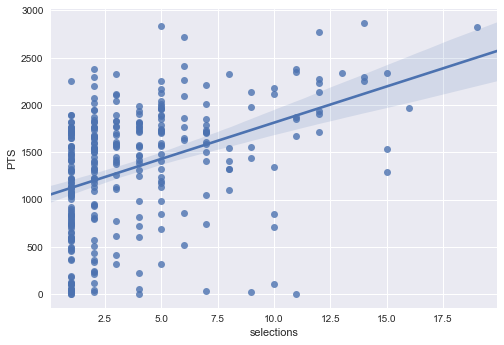

In [1048]:
sns.regplot(mega_training.selections, mega_training.PTS)
plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


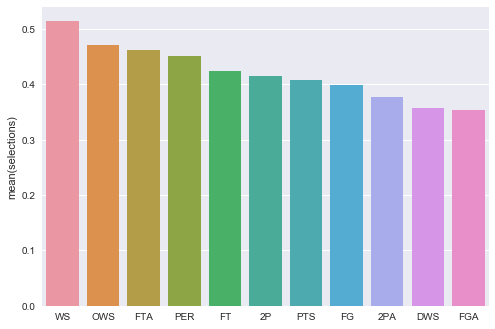

In [1024]:

corr['selections'].sort_values(ascending=False).head(15)
corr['selections'].sort_values(ascending=False).head()
corr = corr['selections'].sort_values(ascending=False)
sns.barplot(x=corr.index[1:12], y=corr[1:12])
plt.show()



## Feature selection and Modelling

In [1090]:

b = SelectKBest(f_regression, k=15)
b.fit(mega_training._get_numeric_data(), mega_training.selections)
cols = b.get_support()
cols = mega_training._get_numeric_data().loc[:, cols].columns
cols = [x for x in cols if x != 'selections']
cols

/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


['2P',
 '2PA',
 'DWS',
 'FG',
 'FGA',
 'FT',
 'FTA',
 'MP',
 'OWS',
 'PER',
 'PTS',
 'TRB',
 'Unnamed: 0_x',
 'WS',
 'WS/48']

## Train test split

In [1091]:
from sklearn.model_selection import train_test_split # Split into train test data

train_features, test_features, train_outcome, test_outcome = train_test_split(
    mega_training[cols],
    mega_training.selections,
    test_size = 0.20,
    random_state = 11
)

In [1092]:
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()# for making pipelines
scaler = MinMaxScaler()
pipe = make_pipeline(poly, scaler, Ridge())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 3)}
grid = GridSearchCV(pipe, param_grid, scoring="r2", verbose=1)
grid.fit(train_features, train_outcome)
print(grid.score(test_features, test_outcome))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
0.910646063808


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


Graph of Predicted labels vs True Labels


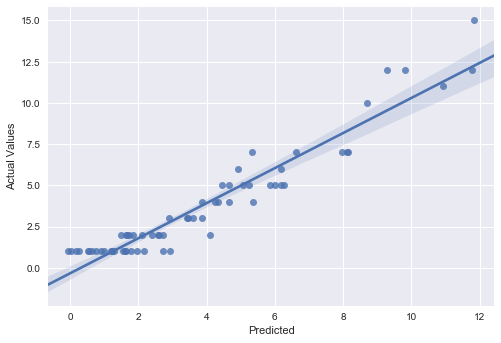

In [1034]:
import seaborn as sns
print('Graph of Predicted labels vs True Labels')
ax =sns.regplot(x=grid.predict(test_features),y=test_outcome )
ax.set(xlabel='Predicted', ylabel='Actual Values')
plt.show()

In [452]:
from sklearn.ensemble import RandomForestRegressor

In [1030]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
regr.fit(train_features, train_outcome)
predictions = regr.predict(test_features)
predictions = [x if x >=0 else 0 for x in predictions]
regr.score(test_features,test_outcome)

0.96046335476411593

Graph of Predicted labels vs True Labels


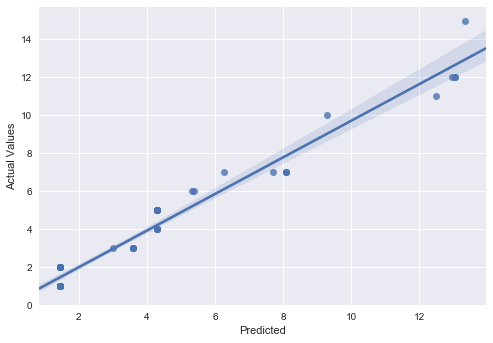

In [1031]:
import seaborn as sns
print('Graph of Predicted labels vs True Labels')
ax = sns.regplot(x=regr.predict(test_features),y=test_outcome )
ax.set(xlabel='Predicted', ylabel='Actual Values')
plt.show()

In [1078]:
# from sklearn.linear_model import LogisticRegression
# regr = LogisticRegression()
# regr.fit(train_features, train_outcome)
# predictions = regr.predict(test_features)
# predictions = [x if x >=0 else 0 for x in predictions]
# regr.score(test_features,test_outcome)

In [1097]:
final_training_features[final_training_features.name == 'Stephen Curry']

,ATL,BAL,BLB,BOS,BRK,BUF,CHA,CHH,CHI,CHO,CHP,CHZ,CIN,CLE,DAL,DEN,DET,FTW,GSW,HOU,IND,INO,KCK,KCO,LAC,LAL,MIA,MIL,MIN,MLH,MNL,NJN,NOH,NOJ,NOP,NYK,NYN,OKC,ORL,PHI,PHO,PHW,POR,ROC,SAC,SAS,SDC,SDR,SEA,SFW,STL_x,SYR,TOR,TOT,UTA,WAS,WSB,C,C-F,F,F-C,F-G,G_x,G-F,2P,2P%,2PA,3P,3P%,3PA,3PAr,AST,AST%,Age,BLK,BLK%,BPM,DBPM,DRB,DRB%,DWS,FG,FG%,FGA,FT,FT%,FTA,FTr,G_y,GS,MP,OBPM,ORB,ORB%,OWS,PER,PF,PTS,Player,Pos,STL_y,STL%,TOV,TOV%,TRB,TRB%,TS%,Tm,USG%,Unnamed: 0,Unnamed: 0_x,Unnamed: 0_y,VORP,WS,WS/48,Year,birth_date,blank2,blanl,college,eFG%,height,name,position,selections,weight,year_end,year_start


In [1142]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
regr.fit(train_features, train_outcome)
print("Stephen Curry : " + str(regr.predict(steph[cols].dropna())))
print("Kyrie Irving : " + str(regr.predict(kyrie[cols].dropna())))

# predictions = [x if x >=0 else 0 for x in predictions]
# regr.score(mega_training[mega_training.name == 'Stephen Curry'][cols],test_outcome)

Stephen Curry : [ 5.47284037]
Kyrie Irving : [ 5.38215166]
